# Run the following 2 blocks. 
## Then, start where it says Step 1/6. Run all blocks unless specified otherwise.

Make sure lmfit, ipympl, and ipywidgets are installed in your python environment!

In [1]:
import numpy as np
import struct
import array
import pandas as pd

import ipywidgets as widgets
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, MaxNLocator)

from lmfit import Model
from lmfit.model import save_modelresult, load_modelresult

import sys
import tkinter
from tkinter.filedialog import askopenfilenames

In [2]:
### The code block below is modified by Tiger Mou from the Python3convert-multipak-to-XPSPEAK-columbia.py file that was originally written by Robert Forest in Python 2, modified for Python 3 by Hansen Mou. Plotting and fitting was written by Hansen Mou.

### This block imports the spe file.

class XSpectrum:

    def __init__(self):
        self._regions = []
        self._XPS_REGION_START_STR = b'DP'
        self._XPS_HEADER_SIZE = 42
   
    def load_xps(self, path):
        """
        Read and parse XPS file according to the reverse engineering of
        Robert Forest's Python3convert-multipak-to-XPSPEAK-columbia.py
        """
        file_str = ""
        # We read in the entire file because iterating through is tedious.
        with open(path, 'rb') as f:
            print('Reading XPS from ' + path)
            file_str = f.read();
            f.close()

        version_str = file_str[0:11].decode('utf-8')
        print(f'File version is: {version_str}')

        idx = file_str.find(self._XPS_REGION_START_STR) + len(self._XPS_REGION_START_STR)
        while idx != -1:
            print(f'IDX: {idx}')
            (region, size) = self.__xps_read_region(file_str, idx)
            self._regions.append(region)
            idx = file_str.find(self._XPS_REGION_START_STR, idx + size) + len(self._XPS_REGION_START_STR)

        print('Done!')
    
  
    def load_spe(self, path):
        """
        Read and parse SPE file according to the reverse engineering of
        Robert Forest's Python3convert-multipak-to-XPSPEAK-columbia.py
        """
        with open(path, 'rb') as f:
            print('Reading SPE from ' + path)
            num_regions = self.__spe_get_number_of_regions(f)
            BE_parameters = self.__spe_get_BE_parameters(f, num_regions)
            self.__spe_convert_multipak_file(f, BE_parameters, num_regions)
        print('Done!')

    # XPS helper functions
    def __xps_read_region(self, file_str, idx):
        """
        """
        curr_reg = dict()

        """ Header contains: (total 42 bytes)
        0: region_size (2 bytes)
        1: unknown: uint 655353 (4)
        2: 20 characters for the region_name, with whitespace padding (20)
        3: region_size again ?? (2)
        4: unknown: int of 1 (2)
        5: region_size + 1 (2)
        and 10 zeros to end the header (10)
        """
        region_header = struct.unpack_from('<HI20sHHH10x', file_str, idx)
        print(region_header)
        idx += self._XPS_HEADER_SIZE

        curr_reg['region_size'] = region_header[0]
        curr_reg['region_name'] = region_header[2].strip()
        
        # Read region be
        curr_reg['be_data'] = np.array(struct.unpack_from(f'<{region_header[0]}f', file_str, idx))
        idx += region_header[0] * 4

        # Strange whitespace of 1, region_size+1, and 10 zeros
        unknown_whitespace = struct.unpack_from('<HH10x', file_str, idx)
        idx += 14

        # Read region intensity
        curr_reg['intensity'] = np.array(struct.unpack_from(f'<{region_header[0]}f', file_str, idx))
        idx += region_header[0] * 4

        """ Footer contains:
        0: max_BE
        1: min_BE
        2: max_intensity
        3: min_intensity
        and LOTS of whitespace for some reason...
        """
        region_footer = struct.unpack_from('<4f', file_str, idx)
        idx += 76

        curr_reg['max_be'] = region_footer[0]
        curr_reg['min_be'] = region_footer[1]
        curr_reg['max_intensity'] = region_footer[2]
        curr_reg['min_intensity'] = region_footer[3]

        # I think it's nothing but idk why
        region_post_footers = []
        for i in range(6):
            region_post_footers.append(struct.unpack_from(f'<HH10x{region_header[0]}f', file_str, idx + i*18+region_header[0]*4))

        curr_reg['post_footers'] = region_post_footers
        
        region_size = self._XPS_HEADER_SIZE + region_header[0] * 4 * 2 + 14 + 16 + (6 *(2+2+region_header[0]*4+10)) + 18

        return (curr_reg, region_size)


    # SPE helper functions

    def __spe_get_number_of_regions(self, file):
        """
        Returns the total number of elements ("regions") from multi-scan
        """
        file_string = file.read()
        i = file_string.rfind(b'NoSpectralReg: ') + len('NoSpectralReg: ')
        file.seek(i)
        return int(file.readline())

    def __spe_get_BE_parameters(self, file, num_regions):
        """Returns a 2D list of binding energy parameters as strings
        First dimension is the region number
        Second dimension is a list of individual parameters for that region
        Indices: 3-region name, 5-region size, 6-step size, 7-high BE, 8-low BE
        """
        BE_parameters = []
        for line_number in range(num_regions):
            BE_parameters.append(file.readline())
            BE_parameters[line_number] = BE_parameters[line_number].split(b' ')
        return BE_parameters

    def __spe_convert_multipak_file(self, file, BE_parameters, num_regions):
        # Set up regions.
        self._regions = [dict() for _ in range(num_regions)]

        # Go to start of data in multipak file.
        data_size = 0
        for i in range(num_regions):
            data_size += int(BE_parameters[i][5])
        file.seek(-8 * data_size, 2) 

        # Process data in each region.
        for i in range(num_regions):
            # Reference to regions dict.
            curr_reg = self._regions[i]

            region_params = BE_parameters[i]
            curr_reg['max_be'] = float(region_params[7])
            curr_reg['min_be'] = float(region_params[8])
            curr_reg['region_size'] = int(region_params[5])
            intensity_data_double = array.array('d')
            intensity_data_double.fromfile(file, curr_reg['region_size'])
                        
            # Region metadata.  Not sure if useful.
            curr_reg['region_name'] = region_params[3]

            # I guess XPS format doesn't support double?
            curr_reg['be_data'] = np.linspace(curr_reg['max_be'], curr_reg['min_be'], curr_reg['region_size'])

            curr_reg['intensity'] = np.array(intensity_data_double)

            curr_reg['min_intensity'] = min(curr_reg['intensity'])
            curr_reg['max_intensity'] = max(curr_reg['intensity'])

def get_file_names():    
    root = tkinter.Tk()
    root.withdraw()
    root.attributes('-topmost',True)
    file_list = askopenfilenames(parent=root, title='Open XPS file',
                                              filetypes=[('.spe', '*.spe')])
    file_list = root.tk.splitlist(file_list) #workaround for Windows bug
    root.destroy()
    return file_list

def get_import_fit():    
    root = tkinter.Tk()
    root.withdraw()
    root.attributes('-topmost',True)
    file_list = askopenfilenames(parent=root, title='Import XPS fit',
                                              filetypes=[('.JSON', '*.JSON')])
    file_list = root.tk.splitlist(file_list) #workaround for Windows bug
    root.destroy()
    return file_list

### Shirley background algorithm

### Brief explanation of the algorithm: Shirley background is generated to be S(E) = y_min + interval * { A(2) / [A(1)+A(2)] }
##  Where S(E) is the background intensity at a given binding energy E
##  A(2) is the area at binding energies less than E, and A(1) is area at binding energies greater than E
##  interval is usually accepted to be the intensity difference of the lower and upper bounds for binding energy, for our background region of interest
##  This implementation first calculates the total area [A(1) + A(2)] by numerically integrating via the trapezoid method to find k_integral, and then k_val is simply " interval / [A(1) + A(2)]"
##  Next we calculate A(2) (designated y_integral) and multiply it with k_val
##  Once the iteration has completed, we add y_min to the background
##  Tolerance is determined by calculating the norm of the difference of the initial and final background arrays. I don't understand how that works, but norm basically indicates the degree of difference between 2 arrays, so the smaller the norm, the higher tolerance. Unit is arbitrary, I think.
def shirley_func(ind_min,ind_max,be_vals):
    shirley_back = np.zeros(be_vals.shape)      ## initialize shirley_background array, same size as the entire domain of the region
    for i in range(ind_min,ind_max+1):          ## populate shirley_back array with values for linear background
        shirley_back[i] = ((y_max - y_min)/(x_max - x_min)) * (be_vals[i] - x_min)
    shirley_back_it = shirley_back.copy()       ## copy shirley_back array for a separate, iterated/manipulated version

    tol = 0.01      ## Tolerance level

    it_max = 10       ## maximum number of iterations
    it = 0              ## initial iteration value

    while it < it_max:
        k_integral = 0.0
        for i in range(ind_max, ind_min):
            k_integral += (be_vals[i+1] - be_vals[i]) * 0.5 * (intensity_vals[i+1] + intensity_vals[i] - 2 * y_min - shirley_back[i+1] - shirley_back[i]) # integration via trapezoid method
        k_val = (y_max - y_min)/k_integral
            
        for i in range(ind_max, ind_min):
            y_integral = 0.0
            for j in range(i, ind_min):
                y_integral += (be_vals[j+1] - be_vals[j]) * 0.5 * (intensity_vals[j+1] + intensity_vals[j] - 2 * y_min - shirley_back[j+1] - shirley_back[j])
            shirley_back_it[i] = k_val * y_integral
        
        if np.linalg.norm(shirley_back_it - shirley_back) < tol:
            shirley_back = shirley_back_it.copy()
            break
        else:
            shirley_back = shirley_back_it.copy()
        it +=1

    if it >= it_max:
        print("max iterations exceeded")

    shirley_back_fin = y_min + shirley_back

    print("Number of iterations: " + str(it))
    return shirley_back_fin
    # print(shirley_back_fin)

    # print(shirley_back_fin)e(figsize=(10,5))

### Gaussian
def gauss(x,E,F,area,m):
    # E = pars['E']
    # F = pars['F']
    # # a = param[2]
    # m = pars['m']
    # model = height* np.exp(-4 * np.log(2) * (1 - m/100) * ((x - E) / F)**2)
    model = (2 * np.sqrt(np.log(2))/(F * np.sqrt(np.pi))) * area * np.exp(-4 * np.log(2) * (1 - m/100) * ((x - E) / F)**2)
    return model

# Note: for Gaussian, FWHM = 2 * sigma * sqrt(2 ln(2))

### Lorentzian
def lorentz(x,E,F,area,m):
    # E = pars['E']
    # F = pars['F']
    # # a = param[2]
    # m = pars['m']
    # model = height / ((1 + 4 * m/100 * ((x - E) / F)**2))
    model = 2 * area / (np.pi * (1 + 4 * m/100 * ((x - E) / F)**2) * F)
    return model
# !!!! I don't understand why this equation shouldn't be multiplied by 2. !!!!

# Note: for Lorentzian, FWHM = 2 sigma

### E = position (eV); F = FWHM; m = % Lorentzian

### Sum G/L
def sum_gl(x,E,F,area,m):
    # E = param[0]
    # F = param[1]
    # a = param[2]
    # m = param[3]
    model = ((1-m/100) * gauss(x,E,F,area,0) + (m/100) * lorentz(x,E,F,area,100))
    return model

### Product G/L
## Has issues with returning the correct area. I think it has to do with how the weight factor 'm' is incorporated. May need to do numerical integration.
def product_gl(x,E,F,area,m):
    # E = pars['E']
    # F = pars['F']
    # # a = param[2]
    # m = pars['m']
    model = (gauss(x,E,F,area,m) * lorentz(x,E,F,area,m))
    return model

### Defining default variable valus
class xps_settings():
    def __init__(self, region="C1s", peak_type="singlet", background_lower_bound=None, background_upper_bound=None, num_peaks=1, param=[284.5,1.0,100,80], peak_id=['p1_'], coup_E=None,coup_area=None, shift=0):
        self.region = region
        self.peak_type = peak_type
        self.background_lower_bound = background_lower_bound
        self.background_upper_bound = background_upper_bound
        self.num_peaks = num_peaks
        self.param = param
        self.peak_id = peak_id
        self.coup_E = coup_E
        self.coup_area = coup_area
        self.shift = shift

# peak_type = "couplets"   # singlet or couplets
# background_lower_bound = 24.8
# # background_upper_bound = 37.25
# num_peaks = 4
# param = [[28,1.0,100,80],[30,1.0,100,80],[30,1.0,100,80],[33,1.0,100,80]]
# peak_id = ['p1_','p1_2_','p2_','p2_2_']
# coup_E = 1.91
# coup_area = (3/4)

# shift = -5.5

# fwhm_min = 0
# fwhm_max = 1.7
# area_min = 0.1
# gl_min = 0
# gl_max = 100

# Step 1/4: Start here! Run the block below to import your SPE file and get a plot of the raw data.
You can mouse over the plot to see the coordinates!

In [8]:
### Import file
file = get_file_names()

data1 = XSpectrum()

if len(file) > 0:
    data1.load_spe(file[0])

### Identify the regions in the imported file
reg_len = len(data1._regions)
label = []
for i in range(reg_len):
    label.append(data1._regions[i]['region_name'].decode('UTF-8'))
print("\nRegions identified: " + str(label))

### Assigning names to each set of data
id_data1 = {}
for i in range(reg_len):
    id_data1[label[i]] = data1._regions[i]

Reading SPE from C:/Users/hm115/Google Drive/Forschung/Data/XPS/XPS Data/Mo2C-film/Mo2C(syn2)/Cu-Mo2C (syn 2) (Sample 2 - 0.3ML)/200304-bare-Mo2C(2)-fine-0004.SPE
Done!

Regions identified: ['C1s', 'Mo3d', 'O1s']


## Optional: Run below to see plots of your raw data

In [9]:
### Plot the raw data
%matplotlib widget
sub_tab=[widgets.Output() for i in range(reg_len)]
tab = widgets.Tab(sub_tab)
for i in range(reg_len):
    tab.set_title(i,label[i].format(i+1))
    with sub_tab[i]:
        fig = plt.figure(figsize=(10,5))
        ax = fig.subplots()
        ax.plot(data1._regions[i]['be_data'], data1._regions[i]['intensity'])
        ax.set_title(label[i],fontweight='bold',fontsize=20)
        ax.invert_xaxis()
        ax.set_xlabel('Binding Energy [eV]',fontweight='bold',fontsize=16)
        ax.set_ylabel('Intensity',fontweight='bold',fontsize=16)
        ax.tick_params(axis='both',which='major',labelsize=14)
        ax.xaxis.set_minor_locator(MultipleLocator(100))
        plt.show(fig)
display(tab)
def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)
plt.connect('motion_notify_event', mouse_move)
# plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

9

# Step 2/4: Set your peak fitting configuration here
## Make sure to comment out any options you don't want to set, but don't complain when things don't appear as you'd like.

### Note: if peak_type = "couplets", then make sure number of parameters is half the number of peaks (since each parameter accounts for 2 peaks)

Here's how the configuration works:

peak\_input = xps\_settings( &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; This line initializes the peak configuration <br /><br />
&emsp;&emsp;&emsp;&emsp;   region =  <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Region name of interest. Make sure name is in "quotes". Default = "C1s" <br /><br />
&emsp;&emsp;&emsp;&emsp;    peak\_type = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Choose either "singlet" or "couplets" else the script will break. Default = "singlet" <br /><br />
&emsp;&emsp;&emsp;&emsp;    background\_lower\_bound = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Pick the lower binding energy for the Shirley Background calculation to start at. Default = lower bound of region <br /><br />
&emsp;&emsp;&emsp;&emsp;    background\_upper\_bound = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Pick the higher binding energy for the Shirley Background calculation to start at. Default = upper bound of region <br /><br />
&emsp;&emsp;&emsp;&emsp;    num\_peaks = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Number of peaks you want to fit in your region. Default = 1 <br /><br />
&emsp;&emsp;&emsp;&emsp;    param = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Peak parameters. Format is as follows: \[\[Binding Energy, FWHM, Peak Area, % Gaussian/Lorentzian], ... ]. Default = \[\[284.5,1.0,100,80]]<br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Note: if peak\_type = "couplets", then make sure number of parameters is half the number of peaks (since each parameter accounts for 2 peaks)<br /><br />
&emsp;&emsp;&emsp;&emsp;    peak\_id = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; List of peak ids for distinguising each peak. Label them however you will, but number of peak ids must be the same as the number for num_peaks. Default = ['p1_'] <br /><br />
&emsp;&emsp;&emsp;&emsp;    coup\_E = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Only used if peak_type = "couplets". This is the eV offset for the secondary peak relative to the main peak. Default = None <br /><br />
&emsp;&emsp;&emsp;&emsp;    coup\_area = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Only used if peak_type = "couplets". This is the area multiplier for the secondary peak relative to the main peak. Default = None <br /><br />
&emsp;&emsp;&emsp;&emsp;    shift = <br />
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Used to shift the final plot by a number of eV. Useful if you know how far to adjust C1s peak, but otherwise you can set this at the end of the script as well. Default = 0 <br />
)

In [10]:
### C1s
# peak_input = xps_settings(
#     region = "C1s",
#     peak_type = "singlet",   # singlet or couplets
#     background_lower_bound = 281.3,
#     background_upper_bound = 295.85,
#     num_peaks = 1,
#     param = [[289.1,1.0,100,80],[292,1.0,100,80]],
#     peak_id = ['p1_','p2_'],
#     # shift = -4.5
#     )

## O1s
peak_input = xps_settings(
    region = "O1s",
    peak_type = "singlet",   # singlet or couplets
    background_lower_bound = 526.2,
    background_upper_bound = 541.5,
    num_peaks = 2,
    param = [[532.5,1.0,100,80],[534.5,1.0,100,80]],
    peak_id = ['p1_','p2_'],
    # shift = -4.5
    )

### N1s
# peak_input = xps_settings(
#     region = "N1s",
#     peak_type = "singlet",   # singlet or couplets
#     background_lower_bound = 396.8,
#     background_upper_bound = 415.65,
#     num_peaks = 4,
#     param = [[401.,1.0,100,80],[404.,1.0,100,80],[409.,1.0,100,80],[411.,1.0,100,80]],
#     peak_id = ['p1_','p2_','p3_','p4_'],
#     # shift = -4.5
#     )

### Pt4f7 
# peak_input = xps_settings(
#     region = "Pt4f7",
#     peak_type = "couplets",   # singlet or couplets
#     background_lower_bound = 69.8,
#     background_upper_bound = 83.7,
#     num_peaks = 4,
#     param = [[74.6,1.0,50,80],[76,50,100,80],[76.2,1.0,50,80],[79,1.0,50,80]],
#     peak_id = ['p1_','p1_2_','p2_','p2_2_'],
#     coup_E = 3.33,
#     coup_area = (3/4),
#     # shift = -4.7
    # )

### V2p3 
# peak_input = xps_settings(
#     region = "V2p3",
#     peak_type = "singlet",   # singlet or couplets
#     background_lower_bound = 521.85,
#     background_upper_bound = 527.55,
#     num_peaks = 1,
#     param = [[524.79,1.0,50,80]],
#     peak_id = ['p1_'],
#     # coup_E = 7.64,
#     # coup_area = (1/2),
#     # shift = -4.7
# )

### Pd3d
# peak_input = xps_settings(
#     region = "Pd3d",
#     peak_type = "couplets",   # singlet or couplets
#     background_lower_bound = 335.1,
#     background_upper_bound = 349.95,
#     num_peaks = 4,
#     param = [[341,1.0,100,80],[341.2,1.0,100,80],[341.9,1.0,100,80],[346.2,1.0,100,80]],
#     peak_id = ['p1_','p1_2_','p2_','p2_2_'],
#     coup_E = 5.26,
#     coup_area = (2/3),
#     shift = -5.5,
#     )

###  Nb3d
# peak_input = xps_settings(
#     region = "Nb3d",
#     peak_type = "couplets",   # singlet or couplets
#     background_lower_bound = 205,
#     # background_upper_bound = 349.95,
#     num_peaks = 4,
#     param = [[207.9,1.0,100,80],[211.4,1.0,100,80],[212,1.0,100,80],[214.7,1.0,100,80]],
#     peak_id = ['p1_','p1_2_','p2_','p2_2_'],
#     coup_E = 2.72,
#     coup_area = (2/3),
#     # shift = -4.5,
#     )

### Ta4f
# peak_input = xps_settings(
#     region = "Ta4f",
#     peak_type = "couplets",   # sing2e2or couplets
#     background_lower_bound = 23.7,
#     background_upper_bound = 34.8,
#     num_peaks = 4,
#     param = [[27,1.0,100,80],[28,1.0,100,80],[31,1.0,100,80]],
#     peak_id = ['p1_','p1_2_','p2_','p2_2_','p3_','p3_2_'],
#     coup_E = 1.91,
#     coup_area = (3/4),
# )

# Step 3: Calculate Shirley Background and plot initial guesses
### Start running the blocks below once satisfied with the configuration.

In [11]:
which_reg = peak_input.region

if peak_input.region not in id_data1:
    print("The region you chose is not present. Please choose from the following:")
    for i in id_data1:
        print("\t"+str(i))
else: 
    be_vals = id_data1[peak_input.region]['be_data']
    activ_reg = label.index(peak_input.region)
    intensity_vals = id_data1[peak_input.region]['intensity']
    print(str(peak_input.region) + " loaded!")
    ### Setting background
    if peak_input.background_lower_bound is None:
        peak_input.background_lower_bound = be_vals[-1]
    if peak_input.background_upper_bound is None:
        peak_input.background_upper_bound = be_vals[0]

    x_min = be_vals[np.abs(be_vals - peak_input.background_lower_bound).argmin()]
    x_max = be_vals[np.abs(be_vals - peak_input.background_upper_bound).argmin()]
    if x_min > x_max:
        print("Please switch your upper and lower bounds.")
    elif x_max not in be_vals or x_min not in be_vals:
        print("Your selected bounds exceed the region. Please set bounds between " + str(be_vals[-1]) + " and " + str(be_vals[0]))
    else:
        ind_min = np.where(be_vals == x_min)[0][0]
        ind_max = np.where(be_vals == x_max)[0][0]

        y_min = id_data1[which_reg]['intensity'][ind_min]
        y_max = id_data1[which_reg]['intensity'][ind_max]

        print("Done!")

        shirley_back_fin = shirley_func(ind_min, ind_max, be_vals)

        ### Plotting initial parameters
        ### param = [peak binding energy, FWHM, area, % gauss/lorentz]

        if peak_input.num_peaks is None:
            num_peaks = 2

        if peak_input.param is None:
            param = [[74.6,1.0,100,80],[78,1.0,100,80]]

        ### if fitting couplets, only need half as many parameters as peaks

        ### Normalizing and zeroing the raw data for fitting
        i = activ_reg

        intensity_zeroed = np.zeros(be_vals.shape)

        for j in range(len(be_vals)):
            intensity_zeroed[j] = intensity_vals[j] - shirley_back_fin[j]

        norm_factor = np.max(intensity_zeroed)

        intensity_norm = intensity_zeroed / norm_factor    

        ### Plots the initial guess on the figure
        initial_fit = []
        if peak_input.peak_type == "couplets":
            for i in range(peak_input.num_peaks):
                if i % 2 == 0:
                    initial_fit.append(sum_gl(be_vals[ind_max:ind_min],*peak_input.param[int(i/2)]) + shirley_back_fin[ind_max:ind_min])
                else:
                    coupled_param = [peak_input.param[int((i-1)/2)][0] + peak_input.coup_E, peak_input.param[int((i-1)/2)][1], peak_input.param[int((i-1)/2)][2] * peak_input.coup_area, peak_input.param[int((i-1)/2)][3]]
                    initial_fit.append(sum_gl(be_vals[ind_max:ind_min],*coupled_param) + shirley_back_fin[ind_max:ind_min])
        elif peak_input.peak_type == "singlet":
            for i in range(peak_input.num_peaks):
                initial_fit.append(sum_gl(be_vals[ind_max:ind_min],*peak_input.param[i]) + shirley_back_fin[ind_max:ind_min])

        initial_fit = np.array(initial_fit)

        # make sure that you multiply the shirley_back_fin by (total number of initial fits minus 1!)
        initial_fit_sum = 0
        initial_fit_sum = np.sum(initial_fit,axis=0) - (peak_input.num_peaks-1) * shirley_back_fin[ind_max:ind_min]

        fig = plt.figure(figsize=(10,5))

        ax = fig.add_subplot(111)

        ax.plot(be_vals, intensity_vals)       ## Plot Region in question
        ax.plot(be_vals[ind_max:ind_min],shirley_back_fin[ind_max:ind_min])    ## Plot Shirley background
        ax.plot(be_vals[ind_max:ind_min],initial_fit_sum)        ## Initial Fit
        for i in range(len(initial_fit)):
            ax.plot(be_vals[ind_max:ind_min],initial_fit[i])        ## Initial Fit

        ax.set_title(label[activ_reg],fontweight='bold',fontsize=20)
        ax.invert_xaxis()
        ax.set_xlabel('Binding Energy [eV]',fontweight='bold',fontsize=16)
        ax.set_ylabel('Intensity',fontweight='bold',fontsize=16)
        ax.tick_params(axis='both',which='major',labelsize=14)
        fig.subplots_adjust(hspace = 0.4)

        # plt.legend(['data', 'background', 'initial guess', 'final fit'])
        plt.legend(['data', 'background', 'overall fit'])

        ax.xaxis.set_minor_locator(MultipleLocator(100))

        # ax[0].set_ylim(400,480)
        # ax[1].set_ylim(0,500)

        def mouse_move(event):
            x, y = event.xdata, event.ydata
            print(x, y)

        plt.connect('motion_notify_event', mouse_move)

        plt.show()

O1s loaded!
Done!
max iterations exceeded
Number of iterations: 10


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [12]:
type(be_vals)

numpy.ndarray

# Sep 4: Once satisfied with the initial guess, run the next block to fit the peaks
Note: need to clean up the parameters output

In [15]:
peak_param_id = ['E','F','area','m']

fwhm_min = 0
fwhm_max = 1.7
area_min = 0.1
gl_min = 0
gl_max = 100

peak_model_list = []
peak_model_list.append(Model(sum_gl,prefix=peak_input.peak_id[0]))
pars = peak_model_list[0].make_params()

pars[peak_input.peak_id[0]+peak_param_id[0]].set(value=peak_input.param[0][0])
pars[peak_input.peak_id[0]+peak_param_id[1]].set(value=peak_input.param[0][1],min=0,max=1.7)
pars[peak_input.peak_id[0]+peak_param_id[2]].set(value=peak_input.param[0][2],min=0.1)
pars[peak_input.peak_id[0]+peak_param_id[3]].set(value=peak_input.param[0][3],min=0,max=100)

if peak_input.peak_type == "singlet":
    for i in range(1,peak_input.num_peaks):
        peak_model_list.append(Model(sum_gl,prefix=peak_input.peak_id[i]))
        pars.update(peak_model_list[i].make_params())

        pars[peak_input.peak_id[i]+peak_param_id[0]].set(value=peak_input.param[i][0])
        pars[peak_input.peak_id[i]+peak_param_id[1]].set(value=peak_input.param[i][1],min=0,max=1.7)
        pars[peak_input.peak_id[i]+peak_param_id[2]].set(value=peak_input.param[i][2],min=0.1)
        pars[peak_input.peak_id[i]+peak_param_id[3]].set(value=peak_input.param[i][3],min=0,max=100)
elif peak_input.peak_type == "couplets":
    for i in range(1,peak_input.num_peaks):
        peak_model_list.append(Model(sum_gl,prefix=peak_input.peak_id[i]))
        pars.update(peak_model_list[i].make_params())
        if i % 2 == 0:
            pars[peak_input.peak_id[i]+peak_param_id[0]].set(value=peak_input.param[int(i/2)][0])
            pars[peak_input.peak_id[i]+peak_param_id[1]].set(value=peak_input.param[int(i/2)][1],min=0,max=1.7)
            pars[peak_input.peak_id[i]+peak_param_id[2]].set(value=peak_input.param[int(i/2)][2],min=0.1)
            pars[peak_input.peak_id[i]+peak_param_id[3]].set(value=peak_input.param[int(i/2)][3],min=0,max=100)
        else:
            ### Set how the parameters for peak2_2 are bound by peak 2

            # peak binding energy
            pars[peak_input.peak_id[i]+peak_param_id[0]].set(expr=peak_input.peak_id[i-1]+peak_param_id[0]+ ' + ' + str(peak_input.coup_E))

            # peak FWHM
            pars[peak_input.peak_id[i]+peak_param_id[1]].set(expr=peak_input.peak_id[i-1]+peak_param_id[1])

            # peak area (could probably automate this by extracting the orbital from the region name)
            pars[peak_input.peak_id[i]+peak_param_id[2]].set(expr=peak_input.peak_id[i-1]+peak_param_id[2] + ' * ' + str(peak_input.coup_area))

            # % GL
            pars[peak_input.peak_id[i]+peak_param_id[3]].set(expr=peak_input.peak_id[i-1]+peak_param_id[3])
                
print(pars)
# print(peak_model_list)
peaks_all = np.array(peak_model_list)
model = np.sum(peaks_all,axis=0)


Parameters([('p1_E', <Parameter 'p1_E', value=532.5, bounds=[-inf:inf]>), ('p1_F', <Parameter 'p1_F', value=1.0, bounds=[0:1.7]>), ('p1_area', <Parameter 'p1_area', value=100, bounds=[0.1:inf]>), ('p1_m', <Parameter 'p1_m', value=80, bounds=[0:100]>), ('p2_E', <Parameter 'p2_E', value=534.5, bounds=[-inf:inf]>), ('p2_F', <Parameter 'p2_F', value=1.0, bounds=[0:1.7]>), ('p2_area', <Parameter 'p2_area', value=100, bounds=[0.1:inf]>), ('p2_m', <Parameter 'p2_m', value=80, bounds=[0:100]>)])


## Step 5/6: Run this block to perform the fit.
### Check the "\[\[Variables]]" section of the output for the fitted parameters

Need to format the output, include the shift

In [16]:
fit = model.fit(intensity_zeroed[ind_max:ind_min],pars,x=be_vals[ind_max:ind_min],method="leastsq")

print(fit.fit_report())

final = (fit.best_fit) + shirley_back_fin[ind_max:ind_min]
comps = fit.eval_components(x=be_vals[ind_max:ind_min])

for i in peak_input.peak_id[:peak_input.num_peaks]:
    comps[i] = comps[i] + shirley_back_fin[ind_max:ind_min]

[[Model]]
    (Model(sum_gl, prefix='p1_') + Model(sum_gl, prefix='p2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1298
    # data points      = 306
    # variables        = 8
    chi-square         = 82571.7917
    reduced chi-square = 277.086549
    Akaike info crit   = 1728.93852
    Bayesian info crit = 1758.72720
##  Warning: uncertainties could not be estimated:
    p1_F:     at boundary
    p2_F:     at boundary
    p2_m:     at boundary
[[Variables]]
    p1_E:     533.403920 (init = 532.5)
    p1_F:     1.70000000 (init = 1)
    p1_area:  472.486578 (init = 100)
    p1_m:     70.2163812 (init = 80)
    p2_E:     535.254058 (init = 534.5)
    p2_F:     1.70000000 (init = 1)
    p2_area:  107.172215 (init = 100)
    p2_m:     99.9999599 (init = 80)


## Step 6/6: Run this block to plot the fit. You may have to change the labels and such.
### Adjust the shift by changing peak_input.shift
Note: add auto-labeling for the sub-peaks, maybe via an additional parameter? Also make the shift more intuitive and user-friendly. Also make colors more easily configurable.

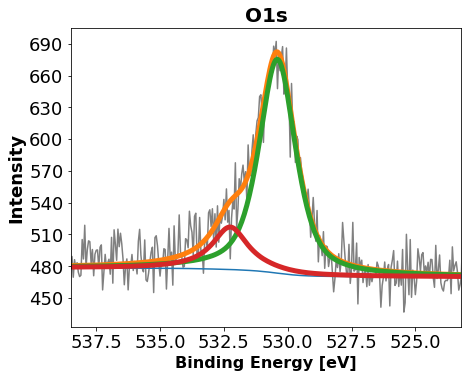

In [17]:
### Uncomment the next line to adjust the shift
peak_input.shift = -3

x_min_shift = x_min + peak_input.shift
x_max_shift = x_max + peak_input.shift

be_vals_shift = be_vals + peak_input.shift

fig = plt.figure(figsize=(7,5.5))

ax = fig.add_subplot(111)

line_wid = 5

ax.plot(be_vals_shift, intensity_vals, color='grey')       ## Plot Region in question
ax.plot(be_vals_shift[ind_max:ind_min],shirley_back_fin[ind_max:ind_min])    ## Plot Shirley background

ax.plot(be_vals_shift[ind_max:ind_min], final, linewidth = line_wid)    ## Final Fit

for i in range(peak_input.num_peaks):
    ax.plot(be_vals_shift[ind_max:ind_min],comps[peak_input.peak_id[i]], label=peak_input.peak_id[i], linewidth = line_wid)

ax.set_title(label[activ_reg],fontweight='bold',fontsize=20)

ax.set_xlim(x_min_shift,x_max_shift)
# ax.set_ylim(20,35)

ax.invert_xaxis()
ax.set_xlabel('Binding Energy [eV]',fontweight='bold',fontsize=16)
ax.set_ylabel('Intensity',fontweight='bold',fontsize=18)
ax.tick_params(axis='both',which='major',labelsize=18)
fig.subplots_adjust(hspace = 0.4)

# plt.legend(['Data', 'Background', 'Fit'],fontsize=10,loc="upper left")

ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

def mouse_move(event):
    x, y = event.xdata, event.ydata
    print(x, y)

plt.connect('motion_notify_event', mouse_move)

plt.show()

In [ ]:

dt = br.tidy(fit)
print(dt.shape)

# Saving results (*Work in Progress*)

In [ ]:
import pybroom as br
# save_data = [[label[activ_reg],"Shift","Binding Energy ("][, peak_input.shift,be_vals_shift, intensity_vals, shirley_back_fin, ind_min, ind_max, x_min, x_max, final]

dt = br.tidy(fit)

shift_val = [None] * dt.shape[1]

shift_val[0] = "Shift"
shift_val[1] = peak_input.shift

save_file = file[0].replace('SPE','xlsx')

# for i in range(peak_input.num_peaks):
    # save_data.append(peak_input.peak_id[i])
    # save_data.append(comps[peak_input.peak_id[i]])

writer = pd.ExcelWriter(f"{save_file}", engine = 'xlsxwriter')

dataframe = pd.DataFrame(dt)
dataframe.loc[len(dataframe)] = shift_val

dataframe.to_excel(writer, sheet_name = label[activ_reg])
writer.save()

print(f"Saved to: {save_file}, sheet: {label[activ_reg]}")

In [ ]:
save_modelresult(fit,file[0].replace('SPE','JSON'))

In [ ]:
import_model = get_import_fit()
# print(import_model[0])
import_fit = load_modelresult(f"{import_model[0]}")
print(import_fit.fit_report())

You're done! I haven't implemented a way to export the data yet, so just copy the plot and the results into powerpoint or something.

Please email me at h.mou@columbia.edu or on Slack with any questions or bugs to report.

Known issues:
- using product_gl method doesn't provide accurate areas
- no way to easily export the data

Right now I have to zero & normalize the raw data, because the fit equations max out at 1 and start at 0 intensity, before fitting. Then I undo everything to move the fitted plot onto the original raw data.